# Makespan policies

In this notebook, we compare various heterogeneity-agnostic and heterogeneity-aware makespan policies, with and without space sharing.

## Import statements

In [1]:
from plotting_utils import *
from utils import get_logfile_paths, average_jct_fn, makespan_fn, prune

## Get list of relevant logfiles and define label mapping

In [2]:
static_logfile_paths = sorted(
    get_logfile_paths(
        "/future/u/deepakn/gavel/logs/cluster_sweep_static_jobs_final/", static_trace=True))
continuous_logfile_paths = sorted(
    get_logfile_paths(
        "/future/u/deepakn/gavel/logs/cluster_sweep_continuous_jobs_final/", static_trace=False))

## Plotting functions

In [3]:
def plot_metric_vs_num_total_jobs(logfile_paths,
                                  clusters,
                                  seeds,
                                  metric_fn,
                                  metric_label,
                                  xmax=None, ymax=None,
                                  output_filename=None):
    plt.figure(figsize=(8, 3))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

    data = {"resource_fraction": [], "metric": [], "seed": []}
    for (v100s, k80s) in clusters:
        p100s = 0
        metrics = {}
        for policy in ["min_total_duration", "min_total_duration_perf"]:
            relevant_logfile_paths = list(reversed(prune(
                logfile_paths, v100s, p100s, k80s, policy)))
            metrics[policy] = {
                x[2]: metric_fn(x[1])
                for x in relevant_logfile_paths}

        metrics_to_plot = [metrics["min_total_duration"][seed] / metrics["min_total_duration_perf"][seed]
                           for seed in seeds]
        import pandas as pd
        data["resource_fraction"] += [float(v100s) / (float(v100s) + float(k80s))
                                      for seed in seeds]
        data["metric"] += metrics_to_plot
        data["seed"] += seeds
    import pandas as pd
    df = pd.DataFrame(data)
    print(df.groupby(["resource_fraction", "seed"]).mean())

    sns.lineplot(x='resource_fraction', y='metric',
                 data=data, ci='sd',
                 markers=True, marker='o')

    ax.set_xlabel("Fraction of V100s")
    ax.set_ylabel(metric_label)
    ax.set_xlim([0.05, 1.05])
    ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_ylim([0, ymax])
    sns.despine()
    
    leg = plt.legend(frameon=False)
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
    bb.y0 += 0.22
    bb.y1 += 0.22
    leg.set_bbox_to_anchor(bb, transform=ax.transAxes)
    
    if output_filename is not None:
        with PdfPages(output_filename) as pdf:
            pdf.savefig(bbox_inches='tight')
    
    plt.show()

In [10]:
def plot_metric_vs_inverse_lambda(logfile_paths,
                                  clusters,
                                  seeds,
                                  metric_fn,
                                  metric_label,
                                  xmax=None,
                                  ymax=None,
                                  output_filename=None):
    from utils import prune

    plt.figure(figsize=(8, 3))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

    data = {"input_job_rate": [], "metric": [], "seed": [],
            "resource_fraction": []}
    for (v100s, k80s) in clusters:
        p100s = 0
        metrics = {}
        for policy in ["max_min_fairness", "max_min_fairness_perf"]:
            relevant_logfile_paths = list(reversed(prune(
                logfile_paths, v100s, p100s, k80s, policy)))
            lambdas = [x[0] for x in relevant_logfile_paths]
            input_job_rates = [3600.0 / x for x in lambdas]
            metrics[policy] = {
                (3600.0 / x[0], x[2]): metric_fn(x[1])
                for x in relevant_logfile_paths}
            keys = sorted(list(set(metrics[policy].keys())))

        metrics_to_plot = []
        for key in keys:
            if metrics["max_min_fairness"][key] is None or \
                metrics["max_min_fairness_perf"][key] is None:
                print(key, metrics["max_min_fairness"][key], metrics["max_min_fairness_perf"][key])
                metrics_to_plot.append(None)
            else:
                metrics_to_plot.append(
                    metrics["max_min_fairness"][key] /
                        metrics["max_min_fairness_perf"][key])
        import pandas as pd
        data["resource_fraction"] += [
            "Frac. of V100s = %.1f" % (float(v100s) / (float(v100s) + float(k80s)))
            for key in keys]
        data["metric"] += metrics_to_plot
        data["input_job_rate"] += [key[0] for key in keys]
        data["seed"] += [key[1] for key in keys]
    df = pd.DataFrame(data)
    print(df.groupby(["input_job_rate", "resource_fraction", "seed"]).mean())

    sns.lineplot(x='input_job_rate', y='metric', style='resource_fraction',
                 hue='resource_fraction',
                 data=data, ci='sd',
                 markers=True)

    ax.set_xlabel("Input job rate (jobs/hr)")
    ax.set_ylabel(metric_label)
    ax.set_xlim([0, xmax])
    ax.set_ylim([0, ymax])
    sns.despine()

    leg = plt.legend(loc='upper left', frameon=False)
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
    bb.y0 += 0.22
    bb.y1 += 0.22
    leg.set_bbox_to_anchor(bb, transform=ax.transAxes)

    if output_filename is not None:
        with PdfPages(output_filename) as pdf:
            pdf.savefig(bbox_inches='tight')

    plt.show()

## Plot makespan improvement vs. fraction of V100s

No handles with labels found to put in legend.


                          metric
resource_fraction seed          
0.1               0     1.399128
                  1     1.533341
                  2     1.373464
0.2               0     1.499276
                  1     1.588435
                  2     1.377788
0.3               0     1.578346
                  1     1.592421
                  2     1.370682
0.4               0     1.604264
                  1     1.524533
                  2     1.353002
0.5               0     1.666300
                  1     1.330557
                  2     1.357304
0.6               0     1.673249
                  1     1.224292
                  2     1.372397
0.7               0     1.491450
                  1     1.088060
                  2     1.322424
0.8               0     1.356331
                  1     1.074051
                  2     1.229077
0.9               0     1.237316
                  1     1.057099
                  2     1.136827
1.0               0     1.000000
          

/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.


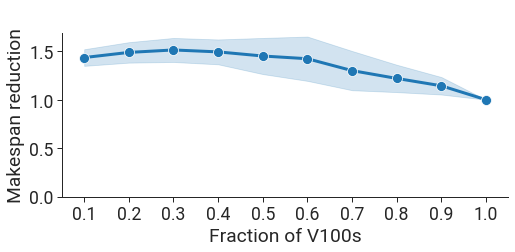

In [5]:
plot_metric_vs_num_total_jobs(
    static_logfile_paths,
    clusters=[(100, 0), (90, 10), (80, 20), (70, 30), (60, 40),
              (50, 50), (40, 60), (30, 70), (20, 80), (10, 90)],
    seeds=[0, 1, 2],
    metric_fn=makespan_fn,
    metric_label="Makespan reduction",
    xmax=None,
    ymax=None,
    output_filename="cluster_sweep/makespan.pdf"
)

(2.799999999377778, 0) None None
(2.799999999377778, 1) None None
(2.799999999377778, 2) None None
(3.2, 0) None None
(3.2, 1) None None
(3.2, 2) None None
(3.6, 0) None None
(3.6, 1) None None
(3.6, 2) None None
(4.0, 0) None None
(4.0, 1) None None
(4.0, 2) None None
(4.400000000977777, 0) None None
(4.400000000977777, 1) None None
(4.400000000977777, 2) None None
                                            metric
input_job_rate resource_fraction    seed          
0.4            Frac. of V100s = 0.1 0     1.724436
                                    1     1.550913
                                    2     1.698038
               Frac. of V100s = 0.5 0     1.482283
                                    1     1.443859
...                                            ...
4.4            Frac. of V100s = 0.5 1     3.216701
                                    2     2.755792
               Frac. of V100s = 1.0 0     1.000000
                                    1     1.000000
                   

/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.


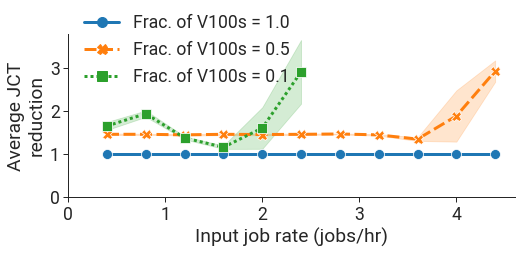

In [11]:
plot_metric_vs_inverse_lambda(
    continuous_logfile_paths,
    clusters=[(100, 0), (50, 50), (10, 90)],
    seeds=[0, 1, 2],
    metric_fn=average_jct_fn,
    metric_label="Average JCT\nreduction",
    xmax=None,
    ymax=None,
    output_filename="cluster_sweep/las.pdf")